Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
        
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3084, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'term', 'of', 'originated', 'as']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.107404
Nearest to he: pygmy, reluctantly, rebounding, visitors, leukocytes, shrines, restaurants, installing,
Nearest to five: camelcase, orthogonality, music, lenten, leonidas, crisis, laplace, fontane,
Nearest to system: holberg, excursions, brixton, competency, monarchical, historicity, enrolled, carl,
Nearest to these: nipple, lien, cavan, hitters, autonomy, undo, agitation, iconography,
Nearest to which: pride, pampas, boy, dct, ramsay, unep, assault, shaykh,
Nearest to four: audiovisual, luddites, involves, greed, alfaro, snegur, wrath, rhotic,
Nearest to its: gomez, mediterranean, wachowski, immortals, hemoglobin, removable, nihon, pareto,
Nearest to so: pandora, defy, benitez, polonium, ostensibly, desylva, stupidity, worked,
Nearest to time: discoveries, workday, jet, keller, stow, simcity, clive, zwickau,
Nearest to also: metalloid, merwara, somehow, overheating, leans, electron, geophysical, gottlieb,
Nearest to however: promising, rvi, 

Average loss at step 52000: 3.441048
Average loss at step 54000: 3.426446
Average loss at step 56000: 3.436425
Average loss at step 58000: 3.394826
Average loss at step 60000: 3.396413
Nearest to he: she, it, they, there, who, we, enabled, originally,
Nearest to five: four, six, eight, seven, three, zero, nine, two,
Nearest to system: systems, inverse, operations, listening, reversing, entity, spaces, kickapoo,
Nearest to these: many, some, both, those, several, various, such, they,
Nearest to which: that, this, what, however, it, csc, who, there,
Nearest to four: five, eight, six, seven, three, nine, zero, two,
Nearest to its: their, his, the, her, whose, lauded, narrations, dacia,
Nearest to so: youths, if, ragged, smoot, lieberman, abdicating, advertiser, relaxing,
Nearest to time: year, day, period, way, place, beggar, distance, kind,
Nearest to also: often, now, usually, still, sometimes, which, currently, typically,
Nearest to however: but, although, though, while, that, which, w

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

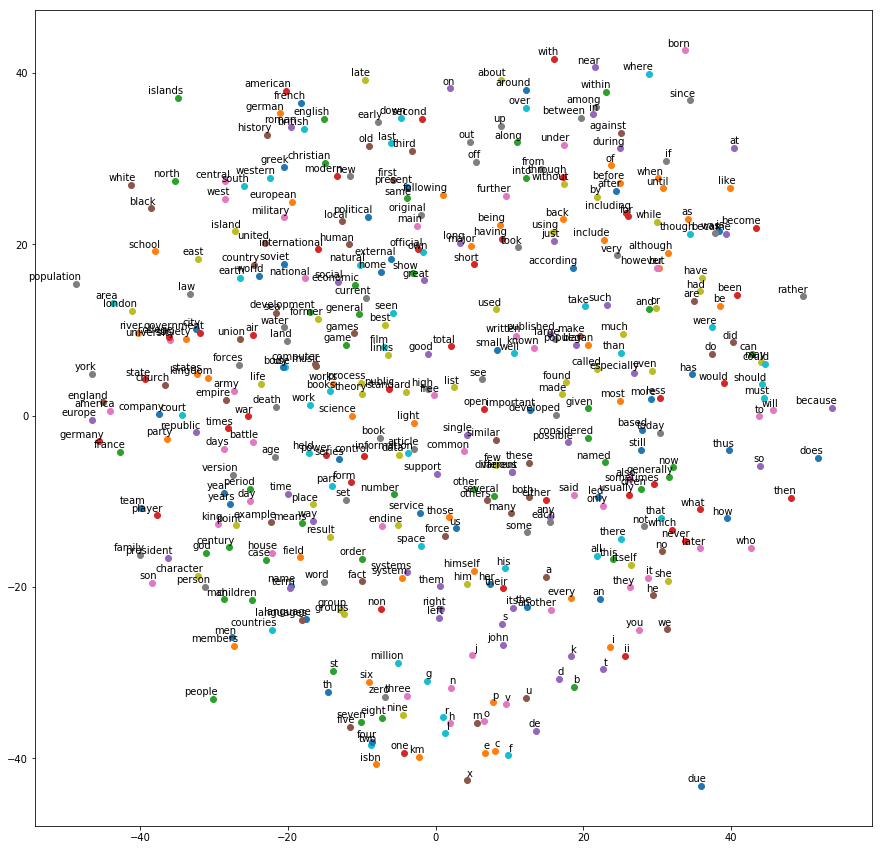

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

## Discussion

In the previous model, the formal way to do it is to provide a training data like (1234) and training label like (3, 14, 87, 1906) but it got lazy to provide such data point (1234, 3) (1234, 14) (1234, 87) (1234, 1906). In the hope that (1234) will map to the average of the 4 words (3, 14, 87, 1906)

Compare to the implementation proposed in http://cs224d.stanford.edu/lecture_notes/LectureNotes1.pdf
We could see that the skip-gram model in this exercise is of more or less like logistic regression. not even a 1 layer NN, which require 2 W matrix and relu function

Reversing the batch in skip-gram is simply another skip-gram model e.g (3, 1234) (14, 1234) (87, 1234) (1906 1234). 
What we going to do is to convert (3, 14, 87, 1906) to a embedding and use it to predict the label (1234)

The following will do
1. Create a batch generation function for CBOW
2. Create a proper implementation of CBOW


In [10]:
data_index = 0

def generate_batch_CBOW(batch_size, context_size):
    batch_size = batch_size * context_size
    global data_index
    assert (context_size + 1) % 2 == 1 # the context for a word should always have even number of elements on each side
    assert batch_size % (context_size) == 0 # should fail if we cannot fit exactly N contexts in one batch
 
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size // context_size, 1), dtype=np.int32)
    # 0,1,2,3 4,5,6,7
    mid_element = context_size // 2
    for i in range(batch_size // context_size):
        buffer = [None] * context_size
        for j in range(context_size + 1):
            idx = (data_index + j) % len(data)
            mid_element_idx = (data_index + mid_element) % len(data)
         
            if idx < mid_element_idx:
                buffer[j] = data[idx]
            elif idx > mid_element_idx:
                buffer[j-1] = data[idx]
            else:
                labels[i,0] = data[mid_element_idx]
        random.shuffle(buffer)
        for j in range(context_size):
            batch[i*context_size + j] = buffer[j]
        data_index = (data_index + 1) % len(data)
     
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])


for context_size in [4, 2] :
    data_index = 0
    batch, labels = generate_batch_CBOW(batch_size=8, context_size=context_size)
    print('\nwith context_size = %d:' % context_size)
    print("context for %s:" % context_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with context_size = 4:
context for 4:
    batch: ['term', 'originated', 'a', 'anarchism', 'as', 'originated', 'term', 'of', 'abuse', 'as', 'a', 'of', 'abuse', 'term', 'first', 'a', 'first', 'used', 'of', 'term', 'of', 'abuse', 'against', 'used', 'against', 'abuse', 'early', 'first', 'first', 'early', 'used', 'working']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with context_size = 2:
context for 2:
    batch: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of', 'abuse', 'term', 'of', 'first', 'used', 'abuse', 'first', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


In [11]:
### initialization of the graph ###
 
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
context_size = 4 # How many words to consider left and right
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.
 
graph_cbow = tf.Graph()
 
with graph_cbow.as_default():
 
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size * context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
 
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    segments = tf.constant([x // context_size for x in range(batch_size * context_size)])
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                                                 stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
 
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    compressed_embeddings = tf.segment_mean(embed, segments) # merging couple of embeded words into one input
    
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=compressed_embeddings,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
 
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
 
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001
 
with tf.Session(graph=graph_cbow) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_CBOW(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s," % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.705972
Nearest to was: conjugated, systematically, compliance, devotee, nazis, kyoto, artistry, clavell,
Nearest to state: hamlet, klansmen, new, biting, longstanding, kashubian, recipes, subduing,
Nearest to of: computationally, hyi, nonstandard, happened, nonpartisan, klang, trainer, expatriates,
Nearest to new: sprays, state, vasco, qam, misr, krause, resonant, utc,
Nearest to be: delightful, establishments, abies, unregulated, occurred, julia, abridgment, visiting,
Nearest to years: syllables, holland, expresses, orphan, term, morley, revenue, belgians,
Nearest to when: stored, january, composite, mucous, declarative, unrwa, ment, repetitive,
Nearest to that: redefinition, micronesian, permanent, muad, realized, limbo, pharmacology, rivalry,
Nearest to used: smuggled, jdf, myth, onerous, photon, giger, quartermaster, or,
Nearest to are: primal, amaranthus, damasus, holida

Average loss at step 52000: 2.978963
Average loss at step 54000: 3.012155
Average loss at step 56000: 3.028606
Average loss at step 58000: 2.884910
Average loss at step 60000: 2.963118
Nearest to was: is, were, became, had, showed, linn, be, being,
Nearest to state: former, government, governments, toc, accordions, subtract, chief, chin,
Nearest to of: cox, intercontinental, savages, entrepreneur, cetacea, biochemists, spandau, tav,
Nearest to new: race, prem, meanwhile, staggered, utc, misr, arnold, hess,
Nearest to be: being, been, is, closeup, was, visiting, clashed, are,
Nearest to years: months, decades, days, syllables, weeks, year, centuries, times,
Nearest to when: if, while, where, although, because, though, after, marischal,
Nearest to that: which, what, how, pharmacology, however, where, muad, listener,
Nearest to used: referred, designed, known, bathing, given, written, applied, rumba,
Nearest to are: were, is, have, include, be, being, various, garnet,
Nearest to if: when,

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

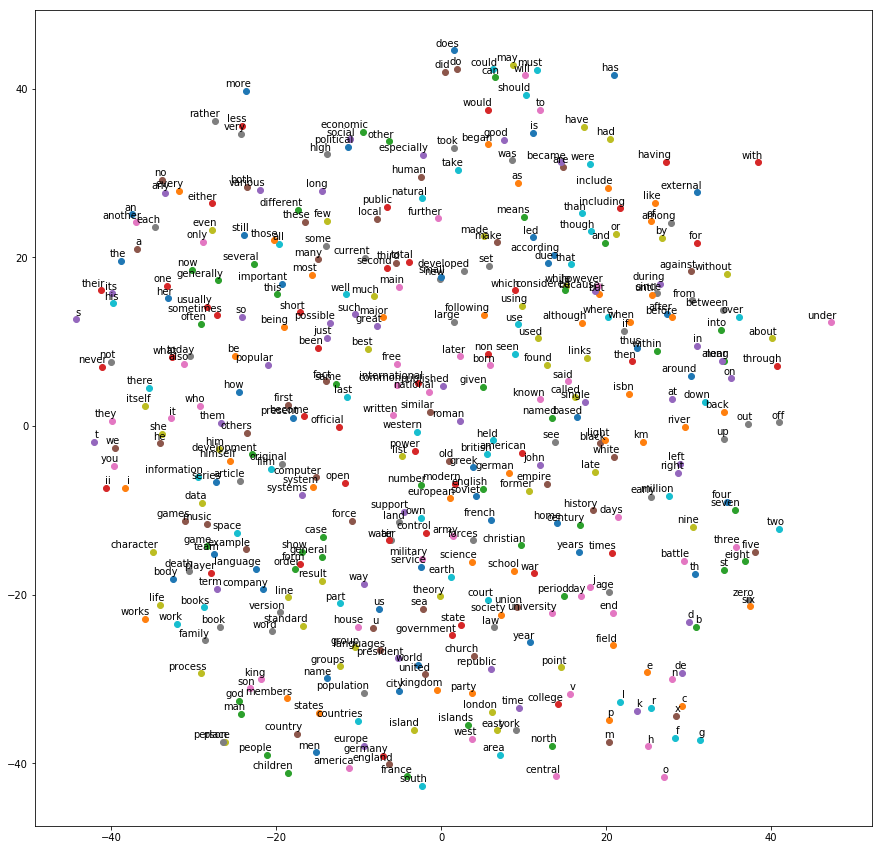

In [14]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)